In [ ]:
!pip install d2l==1.0.0-beta0

Vừa xong ở các phần trước, chúng ta đã giới thiệu cách tiếp cận điển hình để điều chuẩn các mô hình thống kê bằng cách phạt giá trị chuẩn $ℓ_2$ của các trọng số. Theo ngôn ngữ xác suất, ta có thể giải thích kĩ thuật này bằng cách nói ta đã có một niềm tin từ trước rằng các trọng số được lấy ngẫu nhiên từ một phân phối Gauss với trung bình bằng  $0$. Hiểu một cách trực quan, ta có thể nói rằng mô hình được khuyến khích trải rộng giá trị các trọng số ra trên nhiều đặc trưng thay vì quá phụ thuộc vào một vài những liên kết có khả năng không chính xác.

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


#5.6.1. Bàn lại về Quá khớp

Khi có nhiều đặc trưng hơn số mẫu, các mô hình tuyến tính sẽ có xu hướng quá khớp. Tuy nhiên nếu có nhiều mẫu hơn số đặc trưng, nhìn chung ta có thể tin cậy mô hình tuyến tính sẽ không quá khớp. Thật không may, mô hình tuyến tính dựa trên tính ổn định này để khái quát hoá lại kèm theo một cái giá phải trả: Mô hình tuyến tính không màng tới sự tương tác giữa các đặc trưng, nếu chỉ được áp dụng một cách đơn giản. Mỗi đặc trưng sẽ được gán một giá trị trọng số hoặc là âm, hoặc là dương mà không màng tới ngữ cảnh.

Trong các tài liệu truyền thống, vấn đề cốt lõi giữa khả năng khái quát và tính linh hoạt này được gọi là đánh đổi độ chệch - phương sai (bias-variance tradeoff). Mô hình tuyến tính có độ chệch cao (vì nó chỉ có thể biểu diễn một nhóm nhỏ các hàm số) nhưng lại có phương sai thấp (vì nó cho kết quả khá tương đồng trên nhiều tập dữ liệu được lấy mẫu ngẫu nhiên).

Mạng nơ-ron sâu lại nằm ở thái cực trái ngược trên phổ độ chệch - phương sai. Khác với mô hình tuyến tính, các mạng nơ-ron không bị giới hạn ở việc chỉ được xét từng đặc trưng một cách riêng biệt. Chúng có thể học được sự tương tác giữa các nhóm đặc trưng. Chẳng hạn, chúng có thể suy ra được rằng nếu từ “Nigeria” và “Western Union” xuất hiện cùng nhau trong một email thì đó là thư rác, nhưng nếu hai từ đó xuất hiện riêng biệt thì lại không phải.

Ngay cả khi số mẫu nhiều hơn hẳn so với số đặc trưng, mạng nơ-ron sâu vẫn có thể quá khớp. Năm 2017, một nhóm các nhà nghiên cứu đã minh họa khả năng linh hoạt tột cùng của mạng nơ-ron bằng cách huấn luyện mạng nơ-ron sâu trên tập ảnh được gán nhãn ngẫu nhiên. Dù không hề có bất cứ một khuôn mẫu nào liên kết đầu vào và đầu ra, họ phát hiện rằng mạng nơ-ron được tối ưu bằng SGD vẫn có thể khớp tất cả nhãn trên tập huấn luyện một cách hoàn hảo.

Hãy cùng xem xét ý nghĩa của điều này. Nếu nhãn được gán ngẫu nhiên từ một phân phối đều với 10 lớp, sẽ không có bộ phân loại nào có thể có độ chính xác cao hơn 10% trên tập dữ liệu kiểm tra. Khoảng cách khái quát là tận 90%. Nếu mô hình của chúng ta có đủ năng lực để quá khớp tới như vậy, phải như thế nào chúng ta mới có thể trông đợi rằng mô hình sẽ không quá khớp? Nền tảng toán học đằng sau tính chất khái quát hoá hóc búa của mạng nơ-ron sâu vẫn còn là một câu hỏi mở và chúng tôi khuyến khích bạn đọc chú trọng lý thuyết đào sâu hơn vào chủ đề này. Còn bây giờ, hãy quay về bề mặt của vấn đề và chuyển sang tìm hiểu các công cụ dựa trên thực nghiệm để cải thiện khả năng khái quát của các mạng nơ-ron sâu.

# 5.6.2. Khả năng kháng nhiễu

Hãy cùng nghĩ một chút về thứ mà ta mong đợi từ một mô hình dự đoán tốt. Ta muốn mô hình hoạt động tốt khi gặp dữ liệu mà nó chưa từng thấy. Lý thuyết khái quát cổ điển cho rằng: để thu hẹp khoảng cách giữa chất lượng khi huấn luyện và chất lượng khi kiểm tra, ta nên hướng tới một mô hình đơn giản. Sự đơn giản này có thể nằm ở việc đặc trưng có số chiều thấp, điều mà chúng ta đã nghiên cứu khi thảo luận về hàm cơ sở đơn thức trong mô hình tuyến tính ở Section 4.4. Như ta đã thấy khi bàn về suy giảm trọng số (điều chuẩn  ℓ2
 ) ở Section 4.5, chuẩn (nghịch đảo) của các tham số là một phép đo khác cho sự đơn giản. Một khái niệm hữu ích khác để biểu diễn sự đơn giản là độ mượt, tức hàm số không nên quá nhạy với những thay đổi nhỏ ở đầu vào. Ví dụ, khi phân loại ảnh, ta mong muốn rằng việc thêm một chút nhiễu ngẫu nhiên vào các điểm ảnh sẽ không ảnh hưởng nhiều tới kết quả dự đoán.

Vào năm 1995, Christopher Bishop đã chính quy hóa ý tưởng này khi ông chứng minh rằng việc huấn luyện với đầu vào chứa nhiễu tương đương với điều chuẩn Tikhonov [Bishop, 1995]. Công trình này đã chỉ rõ mối liên kết toán học giữa điều kiện hàm là mượt (nên nó cũng đơn giản) với khả năng kháng nhiễu đầu vào của hàm số.

Và rồi vào năm 2014, Srivastava et al. [Srivastava et al., 2014] đã phát triển một ý tưởng thông minh để áp dụng ý tưởng trên của Bishop cho các tầng nội bộ của mạng nơ-ron. Cụ thể, họ đề xuất việc thêm nhiễu vào mỗi tầng của mạng trước khi tính toán các tầng kế tiếp trong quá trình huấn luyện. Họ nhận ra rằng khi huấn luyện mạng đa tầng, thêm nhiễu vào dữ liệu chỉ ép buộc điều kiện mượt lên phép ánh xạ giữa đầu vào và đầu ra.

Ý tưởng này, có tên gọi là dropout, hoạt động bằng cách thêm nhiễu khi tính toán các tầng nội bộ trong lượt truyền xuôi và nó đã trở thành một kỹ thuật tiêu chuẩn để huấn luyện các mạng nơ-ron. Phương pháp này có tên gọi như vậy là bởi ta loại bỏ (drop out) một số nơ-ron trong quá trình huấn luyện. Tại mỗi vòng lặp huấn luyện, phương pháp dropout tiêu chuẩn sẽ đặt giá trị của một lượng nhất định (thường là 50%) các nút trong mỗi tầng về không, trước khi tính toán các tầng kế tiếp.

Để nói cho rõ, mối liên kết đến Bishop là của chúng tôi tự đặt ra. Đáng ngạc nhiên, bài báo gốc về dropout xây dựng cách hiểu trực giác bằng việc so sánh nó với quá trình sinh sản hữu tính. Các tác giả cho rằng hiện tượng quá khớp mạng nơ-ron là biểu hiện của việc mỗi tầng đều dựa vào một khuôn mẫu nhất định của các giá trị kích hoạt ở tầng trước đó, họ gọi trạng thái này là đồng thích nghi. Họ khẳng định rằng dropout phá bỏ sự đồng thích nghi này, tương tự như luận điểm sinh sản hữu tính phá bỏ các gen đã đồng thích nghi.

Thách thức chính bây giờ là làm thế nào để thêm nhiễu. Một cách để làm điều này là thêm nhiễu một cách không thiên lệch sao cho giá trị kỳ vọng của mỗi tầng bằng giá trị kỳ vọng của chính tầng đó trước khi được thêm nhiễu, giả sử rằng các tầng khác được giữ nguyên.

Trong nghiên cứu của Bishop, ông thêm nhiễu Gauss cho đầu vào của một mô hình tuyến tính như sau: Tại mỗi bước huấn luyện, ông đã thêm nhiễu lấy từ một phân phối có trung bình bằng không  $ϵ∼N(0,σ^2)$ cho đầu vào $\mathbf{x}$, thu được một điểm bị nhiễu $\mathbf{x}' = \mathbf{x} + \epsilon$ với kỳ vọng $E[\mathbf{x}'] = \mathbf{x}$.

Với điều chuẩn dropout tiêu chuẩn, ta khử độ chệch tại mỗi tầng bằng cách chuẩn hóa theo tỉ lệ các nút được giữ lại (chứ không phải các nút bị loại bỏ). Nói cách khác, dropout với xác suất dropout $p$ được áp dụng như sau:
$$
\begin{split}\begin{aligned}
h' =
\begin{cases}
    0 & \text{ với~xác~suất } p \\
    \frac{h}{1-p} & \text{ khác }
\end{cases}
\end{aligned}\end{split}
$$
Như ta mong muốn, kỳ vọng không bị thay đổi, hay nói cách khác $E[h'] = h$. Đầu ra của các hàm kích hoạt trung gian $h$ được thay thế bởi một biến ngẫu nhiên $h′$ với kỳ vọng tương ứng.

# 5.6.3. Dropout trong thực tiễn

Nhắc lại về mạng perceptron đa tầng với duy nhất một tầng ẩn có 5 nút ẩn. Kiến trúc mạng được biểu diễn như sau
$$
\begin{split}\begin{aligned}
    \mathbf{h} & = \sigma(\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1), \\
    \mathbf{o} & = \mathbf{W}_2 \mathbf{h} + \mathbf{b}_2, \\
    \hat{\mathbf{y}} & = \mathrm{softmax}(\mathbf{o}).
\end{aligned}\end{split}
$$
Khi chúng ta áp dụng dropout cho một tầng ẩn, tức gán mỗi nút ẩn bằng không với xác suất là  $p$, kết quả có thể được xem như là một mạng chỉ chứa một tập con của các nơ-ron ban đầu. Trong hình dưới, $h_2$ và $h_5$ bị loại bỏ. Hệ quả là, việc tính toán $y$ không còn phụ thuộc vào $h_2$ và $h_5$ nữa và gradient tương ứng của chúng cũng biến mất khi thực hiện lan truyền ngược. Theo cách này, việc tính toán tầng đầu ra không thể quá phụ thuộc vào bất kỳ một thành phần nào trong $h_1,…,h_5$.
![MLP before and after dropout.](http://d2l.ai/_images/dropout2.svg)

Thông thường, chúng ta sẽ vô hiệu hóa dropout tại thời điểm kiểm tra. Với một mô hình đã huấn luyện và một mẫu kiểm tra, ta sẽ không thực hiện loại bỏ bất kỳ nút nào (do đó cũng không cần chuẩn hóa). Tuy nhiên cũng có một vài ngoại lệ. Một vài nhà nghiên cứu sử dụng dropout tại thời điểm kiểm tra như một thủ thuật đề ước lượng độ bất định trong dự đoán của mạng nơ-ron: nếu các dự đoán giống nhau với nhiều mặt nạ dropout khác nhau, ta có thể nói rằng mạng đó đáng tin cậy hơn. Hiện tại, ta sẽ để dành phần ước lượng độ bất định này cho các chương sau.

# 4.6.4. Lập trình từ đầu.

Để lập trình hàm dropout cho một tầng đơn, ta sẽ lấy mẫu từ một biến ngẫu nhiên Bernoulli (nhị phân) với số lượng bằng với số chiều của tầng, trong đó biến ngẫu nhiên đạt giá trị $1$ (giữ) với xác suất bằng $1−p$ và giá trị $0$ (bỏ) với xác suất bằng $p$. Một cách đơn giản để thực hiện việc này là lấy mẫu từ một phân phối đều $U[0,1]$, sau đó ta có thể giữ các nút có mẫu tương ứng lớn hơn $p$ và bỏ đi những nút còn lại.

Trong đoạn mã nguồn bên dưới, ta lập trình hàm `dropout_layer` có chức năng bỏ đi các phần tử trong mảng ndarray đầu vào `X` với xác suất `dropout`, rồi chia các phần tử còn lại cho `1.0-dropout` như đã mô tả bên trên

In [9]:
def dropout_layer(X, dropout):
  assert 0<= dropout <= 1
  if dropout == 1: return torch.zeros_like(X)
  mask = (torch.rand(X.shape) > dropout).float()
  return mask * X / (1.0 - dropout)

Ta có thể thử nghiệm hàm dropout_layer với một vài mẫu. Trong đoạn mã nguồn dưới đây, đầu vào X được truyền qua bước dropout với xác suất lần lượt là 0, 0.5 và 1.

In [11]:
X = torch.arange(16, dtype = torch.float32).reshape((2, 8))
print('dropout_p = 0:', dropout_layer(X, 0))
print('dropout_p = 0.5:', dropout_layer(X, 0.5))
print('dropout_p = 1:', dropout_layer(X, 1))

dropout_p = 0: tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
dropout_p = 0.5: tensor([[ 0.,  2.,  4.,  6.,  0.,  0.,  0.,  0.],
        [ 0.,  0., 20.,  0.,  0.,  0., 28.,  0.]])
dropout_p = 1: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


## 5.6.2.1. Định nghĩa mô hình

Mô hình bên dưới áp dụng dropout cho đầu ra của mỗi lớp ẩn (theo chức năng kích hoạt). Chúng ta có thể đặt xác suất bỏ học cho từng lớp riêng biệt. Một xu hướng phổ biến là đặt xác suất bỏ học thấp hơn gần với lớp đầu vào hơn. Chúng tôi đảm bảo rằng việc bỏ học chỉ hoạt động trong quá trình đào tạo.

In [12]:
class DropoutMLPScratch(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = nn.LazyLinear(num_hiddens_1)
        self.lin2 = nn.LazyLinear(num_hiddens_2)
        self.lin3 = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
        if self.training:
            H1 = dropout_layer(H1, self.dropout_1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, self.dropout_2)
        return self.lin3(H2)

## 5.6.2.2. Training

Phần sau đây tương tự như việc đào tạo MLP được mô tả trước đây.

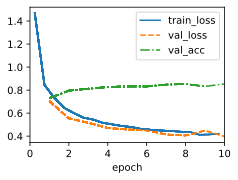

In [13]:
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}
model = DropoutMLPScratch(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

# 5.6.3. Thực hiện ngắn gọn

Với các API cấp cao, tất cả những gì chúng ta cần làm là thêm một Class Dropout sau mỗi lớp được kết nối đầy đủ, chuyển xác suất bỏ học làm đối số duy nhất cho hàm tạo của nó. Trong quá trình đào tạo, Class Dropout  sẽ loại bỏ ngẫu nhiên các đầu ra của lớp trước (hoặc tương đương, các đầu vào của lớp tiếp theo) theo xác suất bỏ học được chỉ định. Khi không ở chế độ đào tạo, Class Dropout chỉ cần chuyển dữ liệu qua trong quá trình thử nghiệm.

In [14]:
class DropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(), nn.LazyLinear(num_hiddens_1), nn.ReLU(),
            nn.Dropout(dropout_1), nn.LazyLinear(num_hiddens_2), nn.ReLU(),
            nn.Dropout(dropout_2), nn.LazyLinear(num_outputs))

Tiếp theo, chúng tôi đào tạo mô hình.

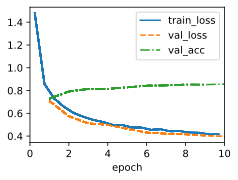

In [15]:
model = DropoutMLP(**hparams)
trainer.fit(model, data)